In [1]:
import os; os.chdir(r'P:\projects\ncps')

In [2]:
import os
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns

from run import read_data
from config import Config
import project.utils as utils
import pandas as pd
from torch import Tensor
import pytorch_lightning as pl
import torch.utils.data as data_utils
from sklearn.preprocessing import MinMaxScaler
from project.model import SequenceLearner
from torchmetrics.functional.regression import mean_absolute_percentage_error


from ncps.torch import LTC

In [3]:
model_paths = ["pl_checkpoints/" + model for model in os.listdir("pl_checkpoints")]

In [4]:
device = "cpu" 
# data related section
data_raw = read_data(Config.PATH)
data_raw = utils.prepare_data(data_raw, station=Config.STATION, features=Config.FEATURES_LIST)

test_data = data_raw.copy()
test_data = utils.make_features(test_data, features=Config.FEATURES_LIST)

x_features, y_features = utils.generate_test_data(
    test_data,
    Config.FILTER_DT_TILL,
    features=Config.FEATURES_LIST,
    push_y_by = 60,
    unit = 'd',
)

x_test_scaler = MinMaxScaler()
x_test_scaler, x_features = utils.normalize_data(
    x_test_scaler,
    x_features)

y_test_scaler = MinMaxScaler()
y_test_scaler, y_features = utils.normalize_data(
    y_test_scaler,
    y_features)

out_features = y_features.shape[-1]
in_features = x_features.shape[-1]

ds = data_utils.TensorDataset(
    Tensor(x_features), Tensor(y_features)
)

dataloader = data_utils.DataLoader(
    ds,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    shuffle=False, 
)

In [19]:
prediction = {}
mapes = {}
mapes_own = {}
maes = {}
model_paths = ["pl_checkpoints/" + file for file in os.listdir("pl_checkpoints/")]
from torchmetrics.regression import MeanAbsolutePercentageError
import torch.nn as nn
from sklearn.metrics import mean_absolute_percentage_error
MAPE = MeanAbsolutePercentageError()
MAE = MeanAbsolutePercentageError()



from ncps.torch import LTC
from ncps.wirings import AutoNCP

wiring = AutoNCP(Config.NUM_LNN_UNITS[0], out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(
    in_features,
    wiring,
    batch_first=True,
    use_swish_activation=Config.USE_SWISH_ACTIVATION[0]
)


for path in model_paths:
    print(path)
    trainer = SequenceLearner.load_from_checkpoint("pl_checkpoints/model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=False_2024-09-08 16-12-12.560153.ckpt", model=ltc_model)
    model = trainer.model
    model.to(device)
    model.eval()
    try:
        prediction[path] = model(Tensor(x_features).view(1, -1, in_features).to(device))[0].detach().numpy()
        pred_values = prediction[path].squeeze(0)
        pred_values_scaled = y_test_scaler.inverse_transform(pred_values)
        tens_pred = torch.from_numpy(pred_values_scaled).squeeze(1)
        y_values_scaled = y_test_scaler.inverse_transform(y_features)
        tens_y = torch.from_numpy(y_values_scaled).squeeze(1)
        score = MAPE(tens_pred, tens_y)
        mapes[path] = score.item()
        score = nn.MSELoss()(tens_pred, tens_y)
        maes[path] = score.item()
        
        y_true = y_values_scaled
        y_pred = pred_values_scaled

        non_zero_mask = y_true != 0
        mapes_own[path] = np.sum(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) / len(y_true) # * 100
    except Exception as e:
        prediction[path] = f"error for this model: {e}"
        pass    

pl_checkpoints/model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=False_2024-09-08 16-12-12.560153.ckpt
pl_checkpoints/model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=False_2024-09-08 16-34-37.356011.ckpt
pl_checkpoints/model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=False_2024-09-08 16-37-18.003829.ckpt


In [20]:
dict(sorted(mapes.items(), key=lambda item: item[1] if not np.isnan(item[1]) else 9999 ))

{'pl_checkpoints/model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=False_2024-09-08 16-12-12.560153.ckpt': 0.40907108783721924,
 'pl_checkpoints/model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=False_2024-09-08 16-34-37.356011.ckpt': 0.40907108783721924,
 'pl_checkpoints/model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=False_2024-09-08 16-37-18.003829.ckpt': 0.40907108783721924}

FileNotFoundError: [Errno 2] No such file or directory: 'P:\\projects\\ncps\\checkpoints_plots\\model-lnn_units=16-lr=0.01-num_epochs=10-lnn_modified=False_2024-09-08 16-12-12.560153.ckpt.png'

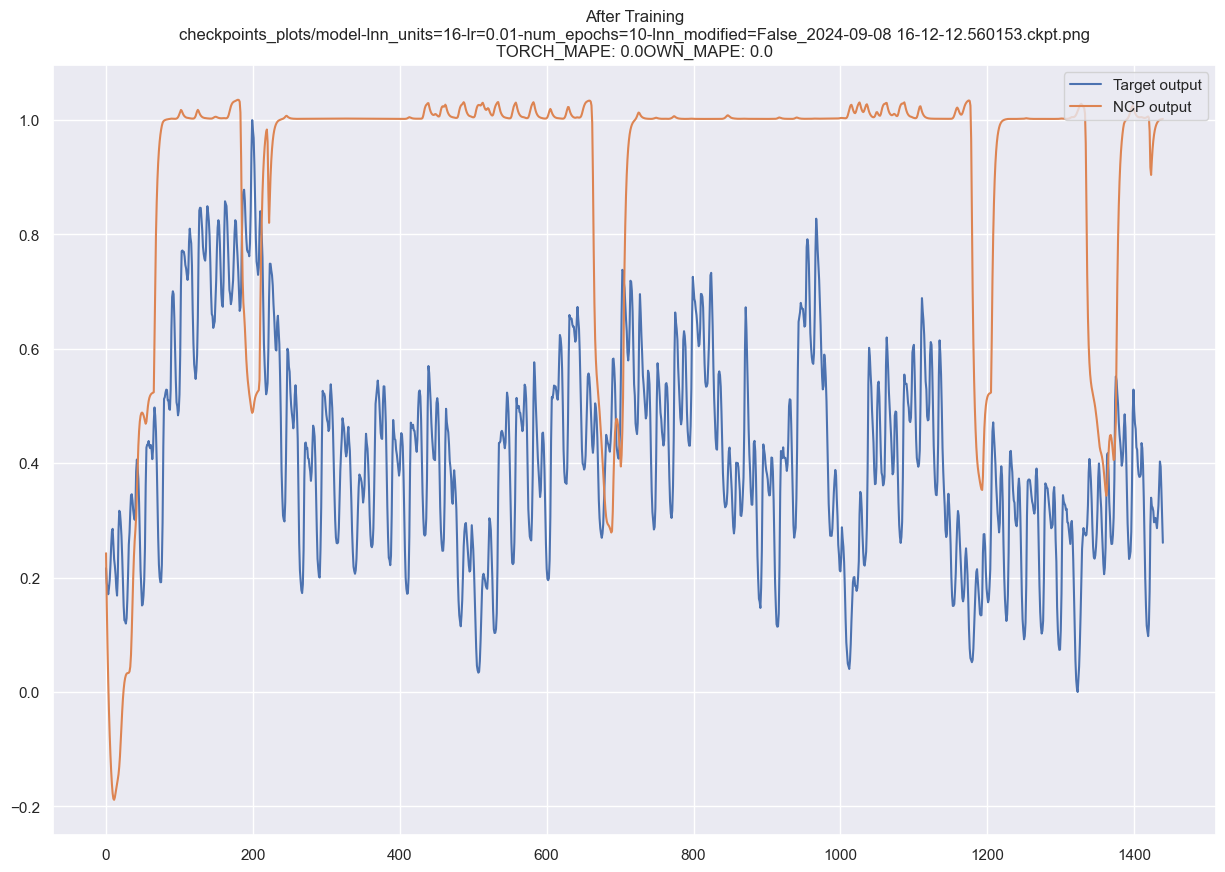

In [21]:
for key, value in prediction.items():
    if "error" in value:
        pass 
    else:
        error_torch = round(mapes[key],0)
        error_own = round(mapes_own[key],0)
        name = "checkpoints_plots/" + key.split("/")[1] + ".png" + "\n" + "TORCH_MAPE: " + str(error_torch) + "OWN_MAPE: " + str(error_own)
        name_for_save = "checkpoints_plots/" + key.split("/")[1] + ".png"
        sns.set_theme()
        plt.figure(figsize=(15, 10))
        plt.plot(y_features[:, 0], label="Target output")
        plt.plot(value[0, :, 0], label="NCP output")

        plt.title(f"After Training\n{name}")
        plt.legend(loc="upper right")
        plt.savefig(name_for_save)
        plt.close()

In [ ]:
pd.set_option("display.max_colwidth", None)
errors_while_loading = ["error" for key, value in prediction.items() if "error" in value]
print("predictions: ", len(prediction))
print("errors: ", len(errors_while_loading))

mape_results = pd.DataFrame(mapes, index=[0]).T.rename(columns={0: "MAPE"}).sort_values(by="MAPE").reset_index()
print(mape_results)

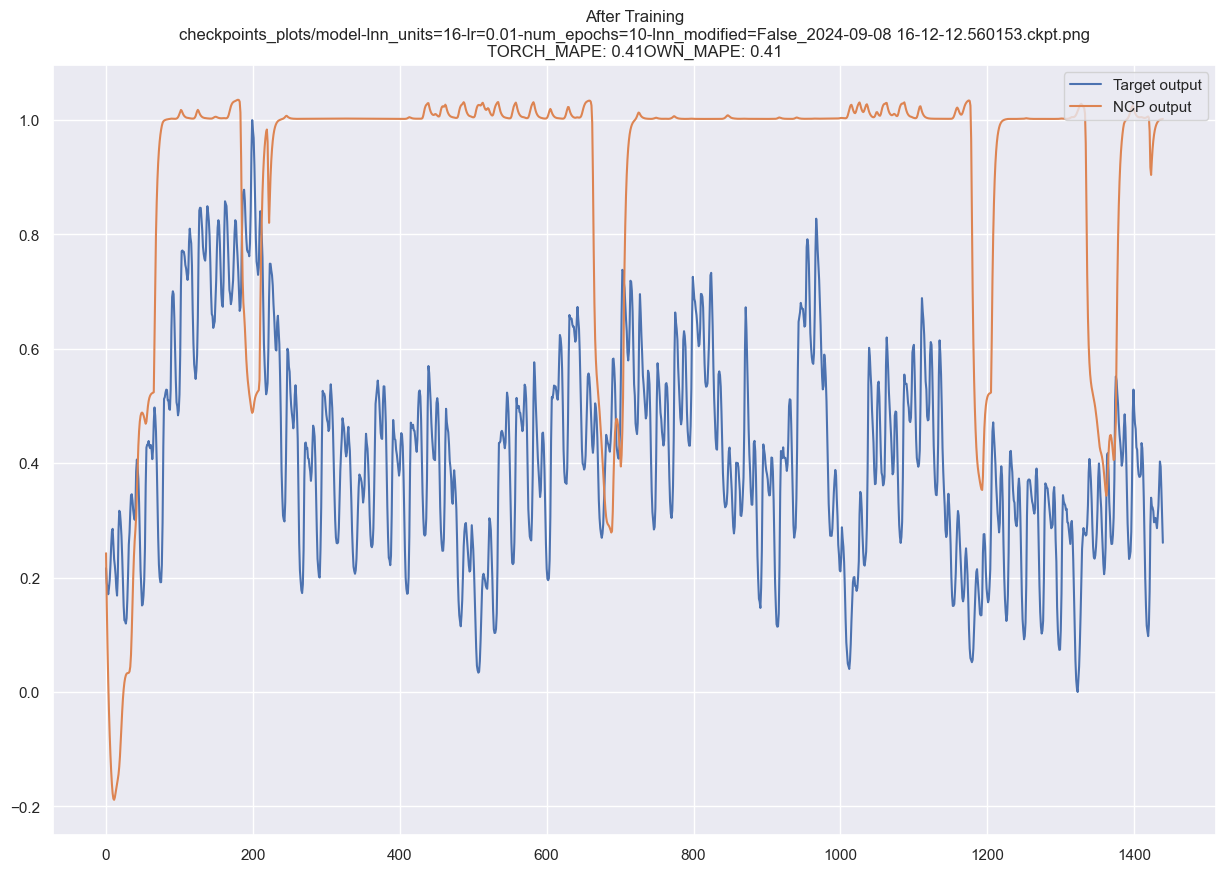

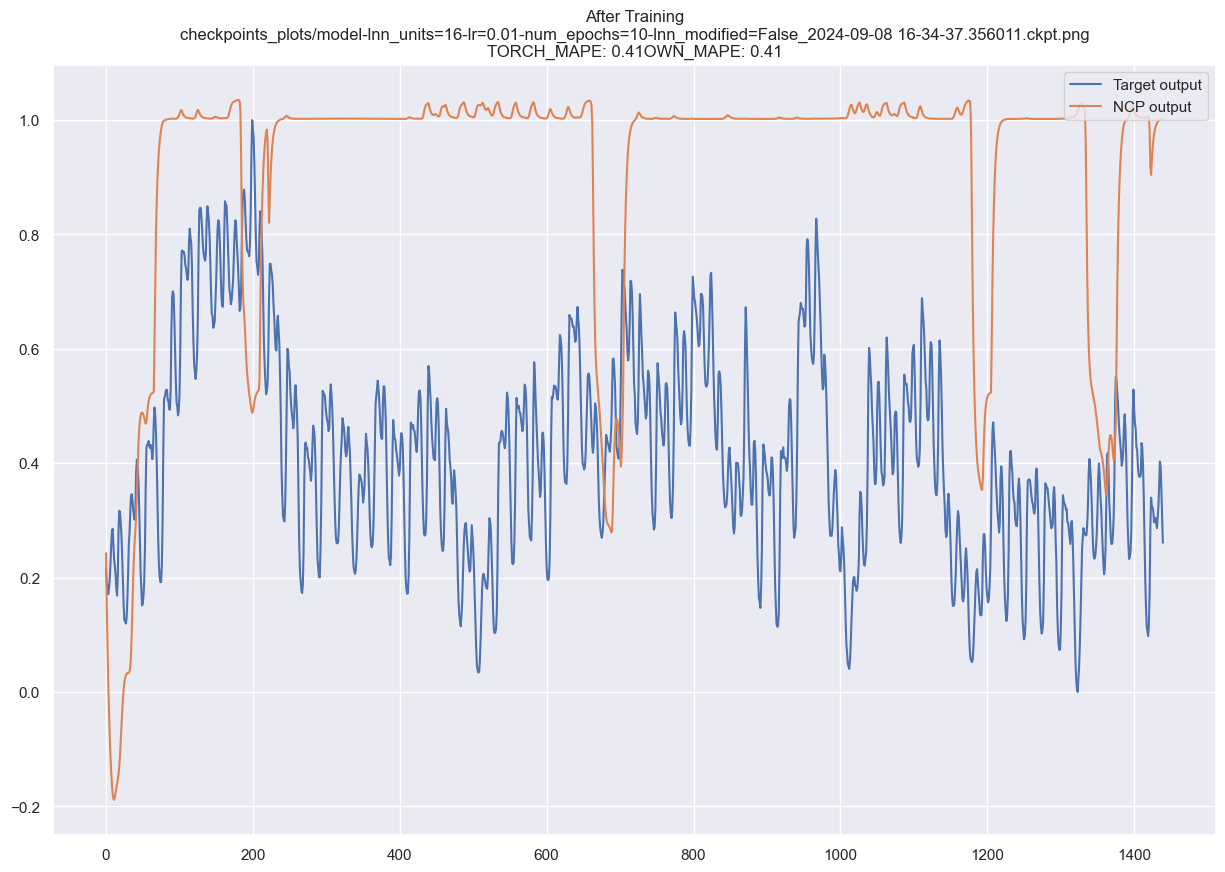

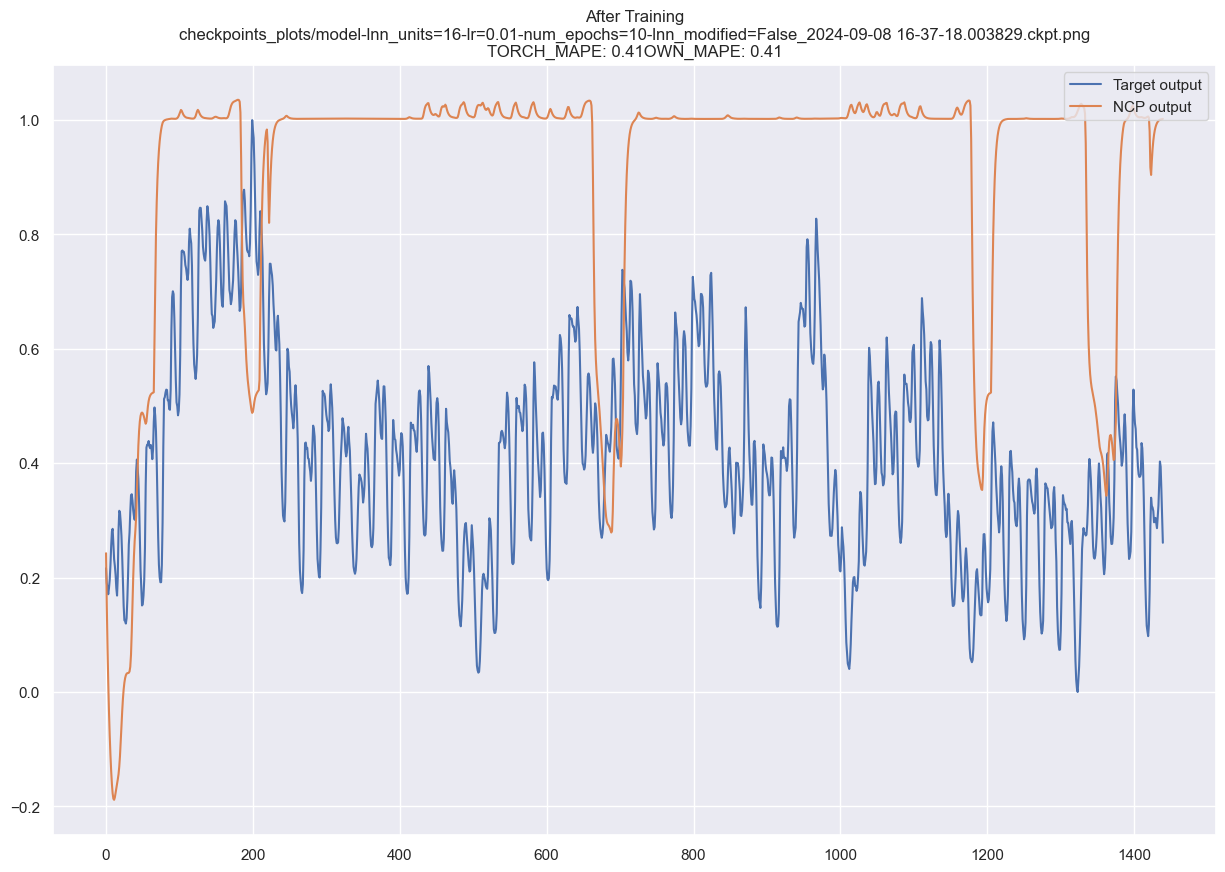

In [22]:
for key, value in prediction.items():
    if "error" in value:
        pass 
    else:
        value = prediction[key].squeeze(0).squeeze(1)
        error_torch = round(mapes[key],2)
        error_own = round(mapes_own[key],2)
        name = "checkpoints_plots/" + key.split("/")[1] + ".png" + "\n" + "TORCH_MAPE: " + str(error_torch) + "OWN_MAPE: " + str(error_own)
        sns.set_theme()
        plt.figure(figsize=(15, 10))
        plt.plot(y_features.squeeze(1), label="Target output")
        plt.plot(value, label="NCP output")
        #plt.ylim([-0.5,1])

        plt.title(f"After Training\n{name}")
        plt.legend(loc="upper right")
        
# value = prediction[mape_results.iloc[0]["index"]]
# name = str(mape_results.iloc[0]["index"])
# sns.set_theme()
# plt.figure(figsize=(15, 10))
# plt.plot(tens_y, label="Target output")
# plt.plot(tens_pred, label="NCP output")
# #plt.ylim([-0.5,1])

# plt.title(f"After Training\n{name}")
# plt.legend(loc="upper right")
# # plt.savefig(name)
